## Modelling

This note book explains the different steps in the machine learning model.For the trigger model we used a Regression model. First the model is trained on the full dataset to obtain the optimal features followed by hyper parameter tunning and model performance estimate using Nested Cross Validation.

* Nested Cross Validation for
    * Feature selection 
    * hyper parameter tunning 
* Performance metrics
* Baseline Models
 








In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
    KFold)
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    SequentialFeatureSelector,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif)
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import pickle
import openpyxl
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import geopandas as gpd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define functions 

In [3]:
# Setting directory
wor_dir="/home/fbf/"


wor_dir="C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model"

os.chdir(wor_dir)

cdir = os.getcwd()


In [4]:
# Import functions
from models.regression.rf_regression import (rf_regression_features,rf_regression_performance,)
from models.regression.xgb_regression import (xgb_regression_features,xgb_regression_performance,)



## Loading the data

In [5]:
combined_input_data=pd.read_csv("data/model_input/df_modelinput_june.csv") 
tphoon_events=combined_input_data[['typhoon','DAM_perc_dmg']].groupby('typhoon').size().to_dict()
### for hyper parameter optimization we looped over typhoon events with at least 100 data entries  
typhoons_with_impact_data= [key for key,value in tphoon_events.items() if value>100]
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]
 

In [7]:

combined_input_data =combined_input_data.filter(['typhoon','Mun_Code','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])

In [8]:
features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary']

In [9]:
def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    #elif ((v_max < x_max)  and  (rainfall_max_6h < y_max) ):
    #elif (v_max < x_max ):
    #value = 0
    else:
        value = np.nan

    return value

combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")

### Feature selection

Feature Selection is an important step in devloping a machine learning model.Data features used to train a machine learning model will influence model performance,less important features can have a negative impact on model performance.
Feature Selection aims to solve the problem of identifying relevant features from a dataset by removing the less important features, which have little/no contribution to our target variable. Feature selection helps to achieve better model accuracy.

There are different techniques for feature selection. For this research we used Recursive feature elimination (RFE),which is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.
To find the optimal number of features we applied cross-validation with RFE on the entire data set. 

 



### Hyper Parameter optimization  

Machine learning models have hyperparameters that you must set in order to customize the model to your dataset. Often the general effects of hyperparameters on a model are known, but how to best set a hyperparameter and combinations of interacting hyperparameters for a given dataset is challenging. There are often general rules of thumb for configuring hyperparameters. A better approach is to objectively search different values for model hyperparameters and choose a subset that results in a model that achieves the best performance on a given dataset. This is called hyperparameter optimization or hyperparameter tuning and is available in the scikit-learn Python machine learning library. [Source](https://machinelearningmastery.com/) 




Hyperparameters are essentila components for machine learning algorithms, they control behaviour and performance of a machine learning model. For a learning algorithm optimal hyperparameter selection, hyperparameter tuning is esstil first step as it helps to achive best model performance on the data set with a reasonable amount of time.[source](https://www.sciencedirect.com/science/article/pii/S1674862X19300047)

To reduce the bias in performance evaluation, model selection should be treated as an integral part of the model fitting procedure, and should be conducted independently in each trial in order to prevent selection bias.[source](https://www.jmlr.org/papers/v11/cawley10a.html)

There are different techniques for Hyperparameters, for this research we used neasted K-fold cross validation technique. 
Nested cross-validation uses inner and outer loops when optimizing the hyperparameters of a model on a dataset, and when comparing and selecting a model for the dataset. This reduced biased evaluation of model performance as different dataset are used to for hyperparameter tunning and model selection.

In our implementation of nested CV the outer loop iterates over typhoon events in our datasets, holiding data for one typhoon for test set and assigning the remaining data as training set. In the inner loop a k-fold CV is applied on the training dataset



### XGBoost Regression 
Obtaining the optimal model

In [124]:
# Full dataset for feature selection

combined_input_data_ = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
 
X = combined_input_data_[features]
y = combined_input_data_["DAM_perc_dmg"]

xgb_search_space = [
    {
        "estimator__learning_rate": [0.1, 0.5, 1],
        "estimator__gamma": [0.1, 0.5, 2],
        "estimator__max_depth": [6, 8],
        "estimator__reg_lambda": [0.001, 0.1, 1],
        "estimator__n_estimators": [100, 200],
        "estimator__colsample_bytree": [0.5, 0.7],
    }
]

selected_features_xgb_regr, selected_params_xgb_regr_full = xgb_regression_features(
    X=X,
    y=y,
    features=features,
    search_space=xgb_search_space,
    min_features_to_select=1,
    cv_splits=5,
    GS_score="neg_root_mean_squared_error",
    objective="reg:squarederror",
    GS_randomized=True,
    GS_n_iter=50,
    verbose=10,
)


print(f"Number of selected features XGBoost Regression {len(selected_features_xgb_regr)}")
print(f"Selected features XGBoost Regression: {selected_features_xgb_regr}")
print(f"Selected Parameters XGBoost Regression: {selected_params_xgb_regr_full}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START estimator__colsample_bytree=0.7, estimator__gamma=2, estimator__learning_rate=0.5, estimator__max_depth=8, estimator__n_estimators=200, estimator__reg_lambda=0.1
[CV 1/5; 1/50] END estimator__colsample_bytree=0.7, estimator__gamma=2, estimator__learning_rate=0.5, estimator__max_depth=8, estimator__n_estimators=200, estimator__reg_lambda=0.1;, score=(train=-0.338, test=-5.807) total time= 3.4min
[CV 2/5; 1/50] START estimator__colsample_bytree=0.7, estimator__gamma=2, estimator__learning_rate=0.5, estimator__max_depth=8, estimator__n_estimators=200, estimator__reg_lambda=0.1
[CV 2/5; 1/50] END estimator__colsample_bytree=0.7, estimator__gamma=2, estimator__learning_rate=0.5, estimator__max_depth=8, estimator__n_estimators=200, estimator__reg_lambda=0.1;, score=(train=-0.459, test=-5.397) total time= 3.0min
[CV 3/5; 1/50] START estimator__colsample_bytree=0.7, estimator__gamma=2, estimator__learning_rate=0

### seleced features 

In [10]:
# Setting the selected features for XGB

selected_features_xgb_regr= ['HAZ_rainfall_max_24h',
                                       'HAZ_v_max',
                                       'HAZ_dis_track_min',
                                       'TOP_mean_slope',
                                       'TOP_mean_elevation_m',
                                       'TOP_ruggedness_stdev',
                                       'TOP_mean_ruggedness',
                                       'TOP_slope_stdev',
                                       'VUL_poverty_perc',
                                       'GEN_with_coast',
                                       'VUL_Housing_Units',
                                       'VUL_StrongRoof_StrongWall',
                                       'VUL_StrongRoof_LightWall',
                                       'VUL_StrongRoof_SalvageWall',
                                       'VUL_LightRoof_StrongWall',
                                       'VUL_LightRoof_LightWall',
                                       'VUL_SalvagedRoof_StrongWall',
                                       'VUL_SalvagedRoof_LightWall',
                                       'VUL_SalvagedRoof_SalvageWall',
                                       'VUL_vulnerable_groups',
                                       'VUL_pantawid_pamilya_beneficiary']

### parameter optimization first based on selected model features 

In [53]:
from sklearn.metrics import mean_absolute_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor


SEED = 314159265



 
def objective(space1 ):
    # Instantiate the classifier
    model = XGBRegressor(n_estimators=int(space1['n_estimators']),
                       eta=space1['eta'],
                       colsample_bytree=space1['colsample_bytree'],
                       learning_rate = space1['learning_rate'],
                       max_depth = int(space1['max_depth']),
                       min_child_weight = int(space1['min_child_weight']),
                       subsample = space1['subsample'],
                       gamma = space1['gamma'])
    eval_set=[(X_train, y_train), ( X_test, y_test)]
    #model.fit( X_train, y_train, eval_set=[( X_test, y_test)], verbose=False)#,eval_metric="mae")
    model.fit( X_train, y_train, eval_set=eval_set, verbose=False)#,eval_metric="mae")
    results = model.evals_result()
    # plt.figure(figsize=(10,7))
    # plt.plot(results["validation_0"]["rmse"], label="Training loss")
    # plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    # plt.axvline(21, color="gray", label="Optimal tree number")
    # plt.xlabel("Number of trees")
    # plt.ylabel("Loss")
    # plt.legend()

    pred = model.predict(X_test)

    # Calculate our Metric - accuracy
    accuracy = mean_absolute_error(y_test, pred)
    print ("SCORE:", accuracy)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': accuracy, 'status': STATUS_OK }

space1 = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 2),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
    # A problem with max_depth casted to float instead of int with
    # the hp.quniform method.
    #'max_depth':  hp.quniform('max_depth', 6, 8, 1),
    'max_depth':  hp.choice('max_depth', np.arange(4, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'eval_metric': 'mae',
    'early_stopping_rounds':20,
    'objective': 'reg:squarederror',
    # Increase this number if you have more cores. Otherwise, remove it and it will default 
    # to the maxium number. 
    'nthread': 8,
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
    'seed': SEED
}
    
trials = Trials()


# Full dataset for feature selection

combined_input_data_ = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
 

X = combined_input_data_[selected_features_xgb_regr]
y = combined_input_data_["DAM_perc_dmg"]

# Setting the train and the test sets for obtaining performance estimate
#df_train_list, df_test_list = splitting_train_test(combined_input_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


best = fmin(fn=objective,
            space=space1,
            algo=tpe.suggest,
            max_evals=2000,
            #trials=trials
            )
print(best)

SCORE:                                                  
1.7789016449811954                                      
SCORE:                                                                            
1.7532025976761543                                                                
SCORE:                                                                            
1.9175487865230363                                                                
SCORE:                                                                            
1.9521801920159432                                                                
SCORE:                                                                              
1.885862603220867                                                                   
SCORE:                                                                              
1.8560859774865046                                                                
SCORE:                                            

### result of parameter optimization  

In [55]:
selected_params_xgb_regr={'colsample_bytree': 1.0, 'eta': 0.05, 'gamma': 1.0, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 80.0, 'subsample': 0.8}
wor_dir="C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model"
file_name = "models/output/v2/selected_params_xgb_regr.p"
path = os.path.join(wor_dir, file_name)
pickle.dump(selected_params_xgb_regr, open(path, "wb"))

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_26500/1924300228.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model\\models/output/v2/selected_params_xgb_regr.p'>
  pickle.dump(selected_params_xgb_regr, open(path, "wb"))


### training model 

In [114]:
# split data into train and test sets

SEED = 314159265
 
test_size = 0.2

# Full dataset for feature selection

combined_input_data_ = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
 

selected_features_xgb_regr_rp= [#'HAZ_rainfall_max_24h',
                                       'HAZ_v_max',
                                       'HAZ_dis_track_min',
                                       'TOP_mean_slope',
                                       'TOP_mean_elevation_m',
                                       'TOP_ruggedness_stdev',
                                       'TOP_mean_ruggedness',
                                       'TOP_slope_stdev',
                                       'VUL_poverty_perc',
                                       'GEN_with_coast',
                                       'VUL_Housing_Units',
                                       'VUL_StrongRoof_StrongWall',
                                       'VUL_StrongRoof_LightWall',
                                       'VUL_StrongRoof_SalvageWall',
                                       'VUL_LightRoof_StrongWall',
                                       'VUL_LightRoof_LightWall',
                                       'VUL_SalvagedRoof_StrongWall',
                                       'VUL_SalvagedRoof_LightWall',
                                       'VUL_SalvagedRoof_SalvageWall',
                                       'VUL_vulnerable_groups',
                                       'VUL_pantawid_pamilya_beneficiary']


X = combined_input_data_[selected_features_xgb_regr_rp]
y = combined_input_data_["DAM_perc_dmg"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)


# fit model no training data
 
params={'colsample_bytree': 1.0,
 'eta': 0.05,
 'gamma': 1.0,
 'learning_rate': 0.025,
 'max_depth': 8,
 'min_child_weight': 1.0,
 'n_estimators': 80.0,
 'nthread' : 8,
 'objective':'reg:squarederror',
 'early_stopping_rounds ':10,
 'subsample': 0.8}


 
from sklearn.metrics import mean_squared_error,mean_absolute_error

 
reg = xgb.XGBRegressor(base_score=0.5,
             booster='gbtree', 
             subsample=0.8,
             eta=0.05,
             max_depth=8, 
             colsample_bylevel=1,
             colsample_bynode=1, 
             colsample_bytree=1,
             early_stopping_rounds=10, 
             eval_metric=mean_absolute_error,
             gamma=1, 
             objective='reg:squarederror',
             gpu_id=-1, 
             grow_policy='depthwise', 
             learning_rate=0.025,
             min_child_weight=1,
             n_estimators=200,        
             random_state=42,
             tree_method="hist",
             )




eval_set=[(X_train, y_train), ( X_test, y_test)]

reg.fit(X, y, eval_set=eval_set)

 
y_pred = reg.predict(X_test)

[0]	validation_0-rmse:8.48712	validation_0-mean_absolute_error:2.30057	validation_1-rmse:9.44146	validation_1-mean_absolute_error:2.52328
[1]	validation_0-rmse:8.34862	validation_0-mean_absolute_error:2.26193	validation_1-rmse:9.27673	validation_1-mean_absolute_error:2.47829
[2]	validation_0-rmse:8.20524	validation_0-mean_absolute_error:2.22451	validation_1-rmse:9.11873	validation_1-mean_absolute_error:2.43736
[3]	validation_0-rmse:8.06017	validation_0-mean_absolute_error:2.18758	validation_1-rmse:8.95242	validation_1-mean_absolute_error:2.39304
[4]	validation_0-rmse:7.92625	validation_0-mean_absolute_error:2.15371	validation_1-rmse:8.80315	validation_1-mean_absolute_error:2.35403
[5]	validation_0-rmse:7.79394	validation_0-mean_absolute_error:2.11951	validation_1-rmse:8.64986	validation_1-mean_absolute_error:2.31428
[6]	validation_0-rmse:7.65639	validation_0-mean_absolute_error:2.08550	validation_1-rmse:8.50533	validation_1-mean_absolute_error:2.27634
[7]	validation_0-rmse:7.53141	vali

In [115]:
y_pred = reg.predict(X)
combined_input_data_['DMG_predicted']=y_pred

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_9940/2279594552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_input_data_['DMG_predicted']=y_pred


<AxesSubplot:xlabel='DAM_perc_dmg', ylabel='DMG_predicted'>

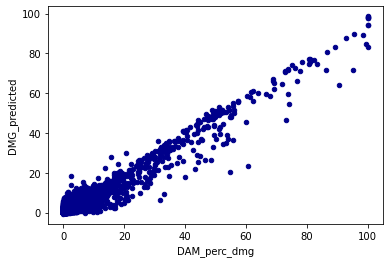

In [116]:
combined_input_data_.plot.scatter(x='DAM_perc_dmg', y='DMG_predicted', c='DarkBlue')

In [117]:

def division(x, y):
    try:
        value = int((x * y)/100)
        
    except:
        value = np.nan
    
    return x if value>x else value  

f_path = os.path.join(wor_dir,"data/all_predisaster_indicators.csv")
 
df_predisasters = pd.read_csv(f_path)

df_ = pd.merge(combined_input_data_[['Mun_Code','typhoon','DAM_perc_dmg','DMG_predicted']], df_predisasters[['Housing Units','Mun_Code']],  how='left', left_on='Mun_Code', right_on = 'Mun_Code') 

df_["number_dmg_Build_prediction"] = df_.apply(lambda x: division(x["Housing Units"], x["DMG_predicted"]), axis=1).values
df_["number_dmg_Build_dromic"] = df_.apply(lambda x: division(x["Housing Units"], x["DAM_perc_dmg"]), axis=1).values
df_im_haz=df_.groupby('typhoon').agg(NUmber_of_affected_municipality=('Mun_Code','count'),
                                     average_ML_Model=('DMG_predicted', average),
                                     average_dromic=('DAM_perc_dmg', average),
                                     Total_buildings_ML_Model=('number_dmg_Build_prediction', sum),
                                     Total_buildings_dromic=('number_dmg_Build_dromic', sum)).sort_values(by='Total_buildings_dromic',ascending=False).reset_index()

 

In [20]:
f_path = os.path.join(wor_dir,"results/predicted_NumberOfBuildingsPerEvent.csv")
 
df_im_haz.to_csv(f_path)

In [182]:
#df_im_haz

In [118]:
# Path to the windout
fpath = os.path.join(wor_dir,"data/model_input/model_input_for_returnperiod.csv")
df_total=pd.read_csv(fpath)

df_total['HAZ_dis_track_min']=75


In [119]:


scenarios_=['HAZ_wind_10','HAZ_wind_100',#'HAZ_wind_1000','HAZ_wind_10000',
            'HAZ_wind_20','HAZ_wind_200',#'HAZ_wind_2000',
            'HAZ_wind_30','HAZ_wind_300',#'HAZ_wind_3000',
            'HAZ_wind_40','HAZ_wind_400',#'HAZ_wind_4000',
            'HAZ_wind_50','HAZ_wind_500',#'HAZ_wind_5000',
            'HAZ_wind_60',#'HAZ_wind_600','HAZ_wind_6000',
            'HAZ_wind_70',#'HAZ_wind_700','HAZ_wind_7000',
            'HAZ_wind_80',#'HAZ_wind_800','HAZ_wind_8000',
            'HAZ_wind_90',#'HAZ_wind_900','HAZ_wind_9000'
            ]

impact_rp={}
impact_rp['Mun_Code']=df_total['Mun_Code'].values
for scenarios in scenarios_:
    df_total_ = df_total#[df_total[scenarios].notnull()]
    df_total_['HAZ_v_max']=df_total_[scenarios]
    X = df_total_[selected_features_xgb_regr_rp]
    index='DMG'+scenarios[3:]   
    impact_rp[index]=reg.predict(X)   
    
impact_df=pd.DataFrame.from_dict(impact_rp)



In [120]:
admin_df =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/input/phl_admin3_simpl2.geojson')


df_imact = pd.merge(
    admin_df[["adm2_pcode", "geometry","adm3_pcode"]],
    impact_df,
    how="left",
    left_on="adm3_pcode",
    right_on="Mun_Code",
)



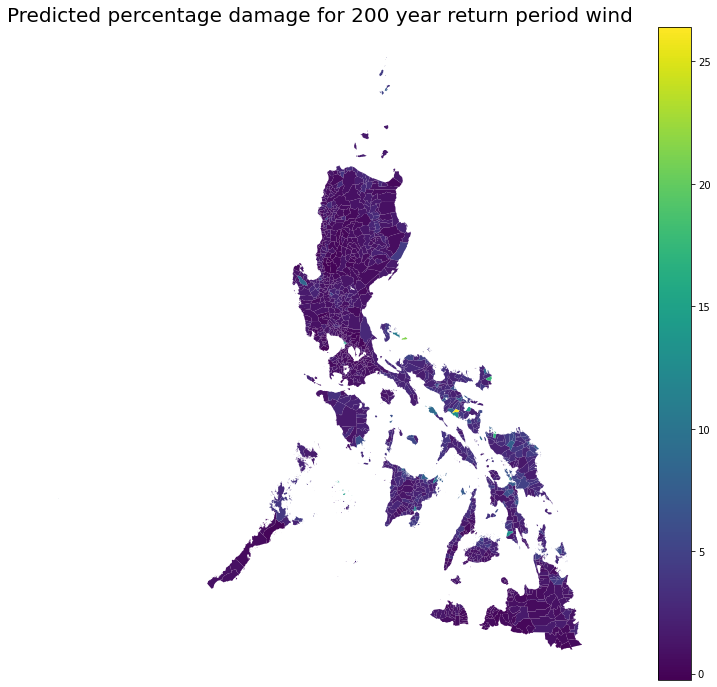

In [121]:
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1)
df_imact.plot(column='DMG_wind_100',ax=ax,legend=True)
leg = ax.get_legend()
plt.title('Predicted percentage damage for 200 year return period wind',fontsize=20)
#leg.set_bbox_to_anchor((1.15,0.5))
ax.set_axis_off()
plt.show()

In [122]:
scenarios_df=[]
for scenarios in scenarios_:
    imp_df=pd.DataFrame()
    index='DMG'+scenarios[3:]   
    imp_df=impact_df[['Mun_Code',index]]
    imp_df['typhoon']='rp'+scenarios[4:]  
    df_1 = pd.merge(imp_df[['typhoon','Mun_Code',index]], df_predisasters[['Housing Units','Mun_Code']],  how='left', left_on='Mun_Code', right_on = 'Mun_Code') 
    df_1["No_dmg_Build_rp"] = df_1.apply(lambda x: division(x["Housing Units"], x[index]), axis=1).values
   
    df_1_agg=df_1.groupby('typhoon').agg(NUmber_of_affected_municipality=('Mun_Code','count'),
                                     average_ML_Model=(index, average),
                                     Total_buildings_rp=('No_dmg_Build_rp', sum)).reset_index()
    scenarios_df.append(df_1_agg)

 


C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_9940/2766010159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_df['typhoon']='rp'+scenarios[4:]
C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_9940/2766010159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_df['typhoon']='rp'+scenarios[4:]
C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_9940/2766010159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [123]:

df=pd.concat(scenarios_df, axis=0)
df

,typhoon,NUmber_of_affected_municipality,average_ML_Model,Total_buildings_rp
0,rpwind_10,1280,1.039858,122519
0,rpwind_100,1280,2.235304,260100
0,rpwind_20,1280,1.280251,148840
0,rpwind_200,1280,2.960433,309021
0,rpwind_30,1280,1.552212,195390
0,rpwind_300,1280,3.184106,342535
0,rpwind_40,1280,1.800497,220040
0,rpwind_400,1280,3.344392,348700
0,rpwind_50,1280,1.939930,243679
0,rpwind_500,1280,3.601903,372237


In [124]:
df_ = pd.merge(impact_df, df_predisasters[['Housing Units','Mun_Code']],  how='left', left_on='Mun_Code', right_on = 'Mun_Code') 

df_['hu']=0.01*df_['Housing Units']


In [125]:
df_

,Mun_Code,DMG_wind_10,DMG_wind_100,DMG_wind_20,DMG_wind_200,DMG_wind_30,DMG_wind_300,DMG_wind_40,DMG_wind_400,DMG_wind_50,DMG_wind_500,DMG_wind_60,DMG_wind_70,DMG_wind_80,DMG_wind_90,Housing Units,hu
0,PH012801000,2.464281,3.814598,2.158606,2.395787,2.075735,3.952307,2.011180,3.758716,2.122187,3.758716,2.073707,2.218162,2.523343,3.814598,411.0,4.11
1,PH012802000,0.474234,0.930124,0.633334,0.987379,0.509560,1.087515,0.586187,1.243926,0.577676,1.160381,0.816922,0.780710,0.780324,0.780324,7717.0,77.17
2,PH012803000,0.512469,1.139405,0.765973,1.212268,0.979350,1.346349,0.752448,1.346349,0.872472,1.652053,0.902271,0.909251,1.059305,1.051811,7155.0,71.55
3,PH012804000,0.612560,0.711790,0.700297,0.749458,0.630112,1.007656,0.693458,0.858189,0.748143,0.853750,0.745852,0.877980,0.958788,0.711790,3534.0,35.34
4,PH012805000,0.330658,0.757559,0.525425,0.736809,0.498544,0.703384,0.424789,0.703384,0.447401,0.832470,0.458302,0.663090,0.632115,0.642198,12348.0,123.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,PH175110000,0.462147,1.176486,0.467518,1.771070,0.553842,1.743379,2.149875,1.639734,1.413391,1.934808,1.413391,1.313495,1.249658,1.249658,32761.0,327.61
1276,PH175111000,2.546903,2.587303,2.262508,2.797982,1.842237,2.986552,2.440752,2.923769,1.868002,3.025432,2.322113,2.965257,2.925605,2.713322,8888.0,88.88
1277,PH175201000,0.801860,2.611374,1.110812,3.543712,1.000890,3.985219,2.687886,3.822157,2.203029,4.567241,2.339433,2.120419,1.986097,2.753569,8248.0,82.48
1278,PH175202000,0.536168,1.597740,0.576559,2.349327,0.773049,2.319728,1.615242,2.170939,1.669648,2.654391,1.669648,1.667325,1.647818,1.657885,9144.0,91.44


In [127]:
df_[['DMG_wind_10', 'DMG_wind_100',# 'DMG_wind_1000','DMG_wind_10000',
     'DMG_wind_20', 'DMG_wind_200',# 'DMG_wind_2000',
       'DMG_wind_30',# 'DMG_wind_300', 'DMG_wind_3000',
       'DMG_wind_40',# 'DMG_wind_400', 'DMG_wind_4000',
       'DMG_wind_50',# 'DMG_wind_500','DMG_wind_5000',
       'DMG_wind_60', #'DMG_wind_600', 'DMG_wind_6000',
       'DMG_wind_70', #'DMG_wind_700', 'DMG_wind_7000',
       'DMG_wind_80', #'DMG_wind_800', 'DMG_wind_8000', 'DMG_wind_90', 'DMG_wind_900','DMG_wind_9000'
       ]].multiply(df_.hu, axis=0) 



,DMG_wind_10,DMG_wind_100,DMG_wind_20,DMG_wind_200,DMG_wind_30,DMG_wind_40,DMG_wind_50,DMG_wind_60,DMG_wind_70,DMG_wind_80
0,10.128193,15.677999,8.871869,9.846685,8.531271,8.265950,8.722188,8.522934,9.116645,10.370940
1,36.596676,71.777691,48.874370,76.196034,39.322708,45.236056,44.579284,63.041885,60.247399,60.217593
2,36.667161,81.524437,54.805353,86.737809,70.072490,53.837639,62.425366,64.557509,65.056916,75.793295
3,21.647859,25.154668,24.748481,26.485829,22.268173,24.506800,26.439376,26.358420,31.027809,33.883584
4,40.829637,93.543356,64.879444,90.981214,61.560262,52.452910,55.245048,56.591075,81.878359,78.053517
...,...,...,...,...,...,...,...,...,...,...
1275,151.404007,385.428662,153.163475,580.220244,181.444297,704.320524,463.041024,463.041024,430.313993,409.400493
1276,226.368750,229.959484,201.091682,248.684617,163.738024,216.934040,166.028033,206.389407,263.552036,260.027799
1277,66.137391,215.386139,91.619789,292.285377,82.553428,221.696798,181.705825,192.956469,174.892122,163.813318
1278,49.027162,146.097361,52.720556,214.822425,70.687638,147.697740,152.672585,152.672585,152.460243,150.676486


In [ ]:
df.iloc[:,1:].div(df.A, axis=0)

In [ ]:


df_["No_dmg_Build_prediction_20rp"] = df_.apply(lambda x: division(x["Housing Units"], x["DMG_wind_20"]), axis=1).values
df_["No_dmg_Build_prediction_50rp"] = df_.apply(lambda x: division(x["Housing Units"], x["DMG_wind_50"]), axis=1).values
df_["No_dmg_Build_prediction_100rp"] = df_.apply(lambda x: division(x["Housing Units"], x["DMG_wind_100"]), axis=1).values
df_["No_dmg_Build_prediction_200rp"] = df_.apply(lambda x: division(x["Housing Units"], x["DMG_wind_200"]), axis=1).values

 
df_im_haz=df_.groupby('typhoon').agg(NUmber_of_affected_municipality=('Mun_Code','count'),
                                     average_ML_Model=('DMG_predicted', average),
                                     average_dromic=('DAM_perc_dmg', average),
                                     Total_buildings_ML_Model=('number_dmg_Build_prediction', sum),
                                     Total_buildings_dromic=('number_dmg_Build_dromic', sum)).sort_values(by='Total_buildings_dromic',ascending=False).reset_index()

 

In [188]:

impact_df

,Mun_Code,DMG_wind_20,DMG_wind_50,DMG_wind_100,DMG_wind_200
0,PH012801000,3.483093,3.660744,4.531105,3.931465
1,PH012802000,1.554254,1.008443,1.332788,0.774332
2,PH012803000,2.434490,1.992312,3.201991,1.847142
3,PH012804000,1.806215,1.290313,0.959572,0.687671
4,PH012805000,1.229517,0.734938,0.998988,0.597060
...,...,...,...,...,...
1642,PH175913000,5.459911,6.013703,6.422211,8.765953
1643,PH175914000,4.624298,5.204270,7.909065,9.549342
1644,PH175915000,4.826305,5.653036,7.130934,8.570692
1645,PH175916000,2.634747,3.969092,6.559634,8.522996
